In [11]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.utils import shuffle
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder 

In [12]:
class DatasetParser():
    def __init__(self):
        self.csv_path = 'IsLotDataset/path_and_labels.csv'
        self.IMAGE_PATH_KEY = 'image_path'
        self.IS_LOT_KEY = 'is_lot'
        self.split = 1000
       
    
    def load(self):
        df = self.load_origin_dataframe()
        image_paths = df[self.IMAGE_PATH_KEY].tolist()
        images = np.array([mpimg.imread('IsLotDataset/'+path)/255.0 for path in image_paths])
        images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
        labels = np.array(df[self.IS_LOT_KEY].tolist())
        labels = labels.reshape(len(labels),1)
        images, labels = self.unison_shuffled_copies(images, labels)
        onehotencoder = OneHotEncoder()
        labels = onehotencoder.fit_transform(labels).toarray()
        return (images[0:self.split], labels[0:self.split], images[self.split:], labels[self.split:])
    
    def unison_shuffled_copies(self, a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

        
    def load_origin_dataframe(self):
        if os.path.exists(self.csv_path):
            df = pd.read_csv(self.csv_path, sep=',')
            return df
        else:
            print('Could not load '+ORIGIN_CSV)
            return None
        

In [13]:
parser = DatasetParser()

(train_imgs, train_labels, test_imgs, test_labels) = parser.load()

In [14]:
print()
print("X daya Shape: {}".format(train_imgs.shape))
print("Image Shape: {}".format(train_imgs[0].shape))
print("Y data Shape: {}".format(train_labels.shape))
print("Label Shape: {}".format(train_labels[0].shape))
print()
print("Training Set:   {} samples".format(len(train_imgs)))
print("Test Set:       {} samples".format(len(test_imgs)))


X daya Shape: (1000, 128, 128, 1)
Image Shape: (128, 128, 1)
Y data Shape: (1000, 2)
Label Shape: (2,)

Training Set:   1000 samples
Test Set:       95 samples


In [15]:
class ImprovedLenet5():

    def __init__(self, classes, learning_rate=0.0005):

        #tf.reset_default_graph()
        
        self.learning_rate = learning_rate
        self.X = tf.placeholder(tf.float32, (None, 128, 128, 1))
        self.Y = tf.placeholder(tf.float32, [None, classes])
        self.keep_prob = tf.placeholder(tf.float32)

        mu = 0
        sigma = 0.1

        #Layer 1: Convolutional. Input = 128x128x1. Output = 124x124x8.
        conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,8],mean = mu, stddev = sigma))
        conv1_b = tf.Variable(tf.zeros(8))
        conv1 = tf.nn.conv2d(self.X,conv1_w, strides = [1,1,1,1], padding = 'VALID') + conv1_b 
        conv1 = tf.nn.relu(conv1)

        #Pooling. Input = 124x124x8. Output = 62x62x8.
        pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')

        #Layer 2: Convolutional. Output = 58x58x16.
        conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,8,16], mean = mu, stddev = sigma))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
        conv2 = tf.nn.relu(conv2)

        #Pooling. Input = 58x58x16. Output = 29x29x16.
        pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 

        #Flatten. Input = 13x13x16. Output = 13456.
        fc1 = flatten(pool_2)

        #Layer 3: Fully Connected. Input = 2.704. Output = 256.
        fc1_w = tf.Variable(tf.truncated_normal(shape = (13456,256), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(256))
        fc1 = tf.matmul(fc1,fc1_w) + fc1_b
        fc1 = tf.nn.relu(fc1)
        fc1 = tf.nn.dropout(fc1, self.keep_prob)

        #Layer 4: Fully Connected. Input = 256. Output = 128.
        fc2_w = tf.Variable(tf.truncated_normal(shape = (256,128), mean = mu, stddev = sigma))
        fc2_b = tf.Variable(tf.zeros(128))
        fc2 = tf.matmul(fc1,fc2_w) + fc2_b
        fc2 = tf.nn.relu(fc2)
        fc2 = tf.nn.dropout(fc2, self.keep_prob)

        #Layer 5: Fully Connected. Input = 128. Output = 64.
        fc3_w = tf.Variable(tf.truncated_normal(shape = (128,64), mean = mu, stddev = sigma))
        fc3_b = tf.Variable(tf.zeros(64))
        fc3 = tf.matmul(fc2,fc3_w) + fc3_b
        fc3 = tf.nn.relu(fc3)
        fc3 = tf.nn.dropout(fc3, self.keep_prob)

        #Layer 6: Fully Connected. Input = 64. Output = classes.
        fc4_w = tf.Variable(tf.truncated_normal(shape = (64,classes), mean = mu , stddev = sigma))
        fc4_b = tf.Variable(tf.zeros(classes))
        self.logits = tf.matmul(fc3, fc4_w) + fc4_b


        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.Y)
        self.loss_operation = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        self.training_operation = optimizer.minimize(self.loss_operation)

        correct_prediction = tf.equal(tf.argmax(self.logits, axis=1), tf.argmax(self.Y, axis=1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        self.session = tf.Session()


    def fit(self, x_data, y_data, batch_size, num_epochs, x_test, y_test):

        self.session.run(tf.global_variables_initializer())
        num_iterations = int(x_data.shape[0]/batch_size)
        historic_accuracy = np.zeros(num_epochs)
        historic_loss = np.zeros(num_epochs)

        print("Training...")
        print()
        for epoch in range(num_epochs):
            x_data_s, y_data_s = shuffle(x_data, y_data)

            for iteration in range(num_iterations):
                batch_xs = x_data_s[iteration*batch_size:(iteration+1)*batch_size,:]
                batch_ys = y_data_s[iteration*batch_size:(iteration+1)*batch_size,:]
                _ = self.session.run([self.training_operation], feed_dict={self.X: batch_xs, self.Y: batch_ys, self.keep_prob: 0.7})
            
            accuracy_val, loss_val = self.session.run([self.accuracy, self.loss_operation], feed_dict={self.X: batch_xs, self.Y: batch_ys, self.keep_prob: 1.0})
            historic_accuracy[epoch] = accuracy_val
            historic_loss[epoch] = loss_val
            test_acc = self.compute_accuracy(x_test, y_test)
            print('Epoch:', '%03d' % (epoch + 1), 'training acc: {}, test acc: {}, loss: {}'.format(accuracy_val, test_acc, loss_val))

        print("Learning Finished!")
        return historic_accuracy, historic_loss

    def predict(self, x_data):
        output_values = self.session.run(tf.nn.softmax(self.logits, axis=1), feed_dict={self.X: x_data, self.keep_prob: 1.0})
        return output_values

    def compute_accuracy(self, x_data, y_data):
        accuracy_val = self.session.run(self.accuracy, feed_dict={self.X: x_data, self.Y: y_data, self.keep_prob: 1.0})
        return accuracy_val


In [16]:
net = ImprovedLenet5(classes=2, learning_rate=0.0005)

In [17]:
acc, loss = net.fit(x_data=train_imgs,
                    y_data=train_labels,
                    batch_size=100,
                    num_epochs=15,
                    x_test=test_imgs,
                    y_test=test_labels)

Training...

Epoch: 001 training acc: 0.7200000286102295, test acc: 0.6842105388641357, loss: 0.6093054413795471
Epoch: 002 training acc: 0.7699999809265137, test acc: 0.6736842393875122, loss: 0.470833420753479
Epoch: 003 training acc: 0.8600000143051147, test acc: 0.75789475440979, loss: 0.4240212142467499
Epoch: 004 training acc: 0.7400000095367432, test acc: 0.7263157963752747, loss: 0.5472012162208557
Epoch: 005 training acc: 0.8100000023841858, test acc: 0.7789473533630371, loss: 0.3791438937187195
Epoch: 006 training acc: 0.8700000047683716, test acc: 0.75789475440979, loss: 0.3130000829696655
Epoch: 007 training acc: 0.8600000143051147, test acc: 0.7789473533630371, loss: 0.275516152381897
Epoch: 008 training acc: 0.8799999952316284, test acc: 0.7684210538864136, loss: 0.308289498090744
Epoch: 009 training acc: 0.9200000166893005, test acc: 0.7684210538864136, loss: 0.20194478332996368
Epoch: 010 training acc: 0.9100000262260437, test acc: 0.7684210538864136, loss: 0.2454923689

In [9]:
net.compute_accuracy(x_data=test_imgs, y_data=test_labels)

0.8947368

[[0.7530524  0.24694751]]
[1. 0.]


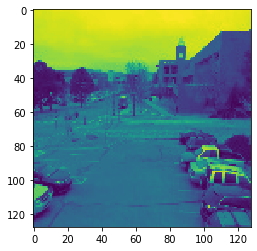

In [10]:
index = 18

train_sample = train_imgs[index].reshape(1, 128, 128, 1)
labl = train_labels[index]

out = net.predict(x_data=train_sample)
print(out)
print(labl)

plt.imshow(train_sample[0,:,:,0])

In [ ]:
"""
1
    Test accurancy: 0.894736
    Train accurancy: 0.93999
    Img size (128x128x1)
    lr 0.0005
    batch_size 100
    num_epochs=10
    keep_prob=0.7
    
"""